## 2-7. 프로젝트: ResNet Ablation Study

### 1) ResNet 기본 블록 구성하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 필요한 라이브러리를 불러오고 GPU 환경을 확인해봅니다.

In [3]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'stage' + str(stage+2) +'_'+ str(i+2) +'_'
        
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv1')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv3')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
            x = layers.Activation('relu')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [4]:
def conv_block(input_tensor, is_50, is_skip, channel, stage):
    conv_name_base = 'stage' + str(stage+2) + '_1_'
    bn_axis = 3
    if stage is 0:
        strides=(1,1)
    else:
        strides=(2,2)
        
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=strides, padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=strides,padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn3')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv3')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel*4, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn4')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), 
                           padding='same', name='stage1_1_conv1')(output)
    output = layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = layers.Activation('relu')(output)
    
    output = layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

#### 2주동안 열심히 구글링 하며 모델을 구축해 보려 했지만 너무 어렵고 힘들었습니다. 진짜 이번 과제 포기할까 하다 그래도 제출은 해야겠기에 집단 지성을 발휘해 복붙해서 모델 학습하고 뭐가 다른지 이해만 하려고 합니다. 아 진짜 자괴감이 드네요 ㅜㅜ

### 2) ResNet-34, ResNet-50 Complete Model

#### ResNet-34

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
______________________________________________________________________________________________

#### ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

In [8]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

In [9]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

#### resnet 34와 50을 input shape에 변화를 줘서 살펴보니 resnet 50이 파라미터값이 더 큰걸 확인할 수 있었습니다. 모델이 더 깊어졌다는 뜻이겠죠?

### 3) 일반 네트워크(plain network) 만들기

In [10]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_228 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [11]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_273 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

#### 기본 모델을 잘 설계하면 손쉽게 일반 모델도 만들수 있다는걸 알게 되었습니다.

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

#### Ablation Study

In [12]:
BATCH_SIZE = 32
EPOCH = 20

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

####  각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [16]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [18]:
ds_info.features["label"].names

['cat', 'dog']

In [19]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

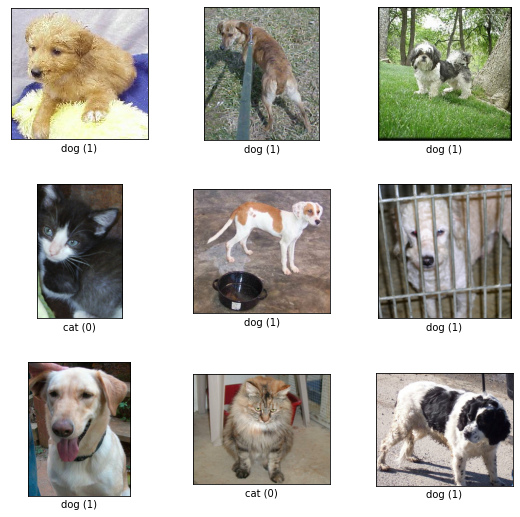

In [20]:
fig = tfds.show_examples(ds_train, ds_info)

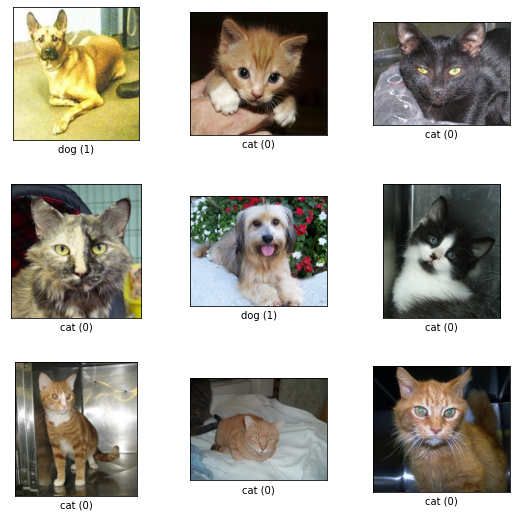

In [21]:
fig = tfds.show_examples(ds_test, ds_info)

#### tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 불러와 살펴보니 고양이와 개로 이루어진 데이터셋이네요.

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 120s 169ms/step - loss: 1.1889 - accuracy: 0.5480 - val_loss: 4.1112 - val_accuracy: 0.4994
Epoch 2/20
581/581 [==============================] - 91s 156ms/step - loss: 0.9470 - accuracy: 0.6145 - val_loss: 2.4496 - val_accuracy: 0.5548
Epoch 3/20
581/581 [==============================] - 85s 146ms/step - loss: 0.8414 - accuracy: 0.6502 - val_loss: 1.3657 - val_accuracy: 0.5807
Epoch 4/20
581/581 [==============================] - 85s 146ms/step - loss: 0.7769 - accuracy: 0.6803 - val_loss: 1.3419 - val_accuracy: 0.5933
Epoch 5/20
581/581 [==============================] - 84s 145ms/step - loss: 0.7055 - accuracy: 0.7208 - val_loss: 0.8010 - val_accuracy: 0.6530
Epoch 6/20
581/581 [==============================] - 84s 145ms/step - loss: 0.6073 - accuracy: 0.7546 - val_loss: 0.7723 - val_accuracy: 0.7065
Epoch 7/20
581/581 [==============================] - 84s 145ms/step - loss: 0.5559 - accuracy: 0.7704 - val_loss: 0.7585 - val_a

In [24]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 85s 134ms/step - loss: 0.9259 - accuracy: 0.5019 - val_loss: 0.7453 - val_accuracy: 0.5100
Epoch 2/20
581/581 [==============================] - 77s 133ms/step - loss: 0.8062 - accuracy: 0.5146 - val_loss: 0.9286 - val_accuracy: 0.4989
Epoch 3/20
581/581 [==============================] - 77s 133ms/step - loss: 0.7724 - accuracy: 0.5267 - val_loss: 2.0289 - val_accuracy: 0.5083
Epoch 4/20
581/581 [==============================] - 77s 133ms/step - loss: 0.7823 - accuracy: 0.5181 - val_loss: 0.7588 - val_accuracy: 0.5219
Epoch 5/20
581/581 [==============================] - 78s 133ms/step - loss: 0.7620 - accuracy: 0.5260 - val_loss: 1.3786 - val_accuracy: 0.5106
Epoch 6/20
581/581 [==============================] - 77s 133ms/step - loss: 0.7588 - accuracy: 0.5294 - val_loss: 0.8687 - val_accuracy: 0.5057
Epoch 7/20
581/581 [==============================] - 78s 133ms/step - loss: 0.7462 - accuracy: 0.5356 - val_loss: 0.8047 - val_ac

In [25]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 191s 264ms/step - loss: 1.6881 - accuracy: 0.5021 - val_loss: 4.3443 - val_accuracy: 0.5213
Epoch 2/20
581/581 [==============================] - 179s 308ms/step - loss: 1.3885 - accuracy: 0.5541 - val_loss: 12.6791 - val_accuracy: 0.4812
Epoch 3/20
581/581 [==============================] - 151s 260ms/step - loss: 1.1862 - accuracy: 0.5725 - val_loss: 9.6337 - val_accuracy: 0.5041
Epoch 4/20
581/581 [==============================] - 151s 260ms/step - loss: 1.0713 - accuracy: 0.5952 - val_loss: 3.0158 - val_accuracy: 0.5345
Epoch 5/20
581/581 [==============================] - 164s 282ms/step - loss: 1.0502 - accuracy: 0.6121 - val_loss: 0.8618 - val_accuracy: 0.6065
Epoch 6/20
581/581 [==============================] - 152s 263ms/step - loss: 1.0186 - accuracy: 0.6308 - val_loss: 0.9758 - val_accuracy: 0.5584
Epoch 7/20
581/581 [==============================] - 153s 263ms/step - loss: 0.9553 - accuracy: 0.6473 - val_loss: 3.0534 

In [26]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 137s 218ms/step - loss: 0.9117 - accuracy: 0.5091 - val_loss: 1.4405 - val_accuracy: 0.5116
Epoch 2/20
581/581 [==============================] - 127s 218ms/step - loss: 0.8383 - accuracy: 0.5176 - val_loss: 3.2064 - val_accuracy: 0.5032
Epoch 3/20
581/581 [==============================] - 126s 217ms/step - loss: 0.8449 - accuracy: 0.5170 - val_loss: 0.9339 - val_accuracy: 0.5076
Epoch 4/20
581/581 [==============================] - 130s 223ms/step - loss: 0.8375 - accuracy: 0.5193 - val_loss: 7.2127 - val_accuracy: 0.5166
Epoch 5/20
581/581 [==============================] - 126s 217ms/step - loss: 0.8305 - accuracy: 0.5164 - val_loss: 2.0439 - val_accuracy: 0.5152
Epoch 6/20
581/581 [==============================] - 126s 217ms/step - loss: 0.8361 - accuracy: 0.5102 - val_loss: 6.0035 - val_accuracy: 0.5260
Epoch 7/20
581/581 [==============================] - 131s 225ms/step - loss: 0.8312 - accuracy: 0.5172 - val_loss: 1.4914 -

#### ResNet-50 vs Plain-50 과 ResNet-34 vs Plain-34에 대해서 학습을 진행했습니다. 

#### 시각화

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

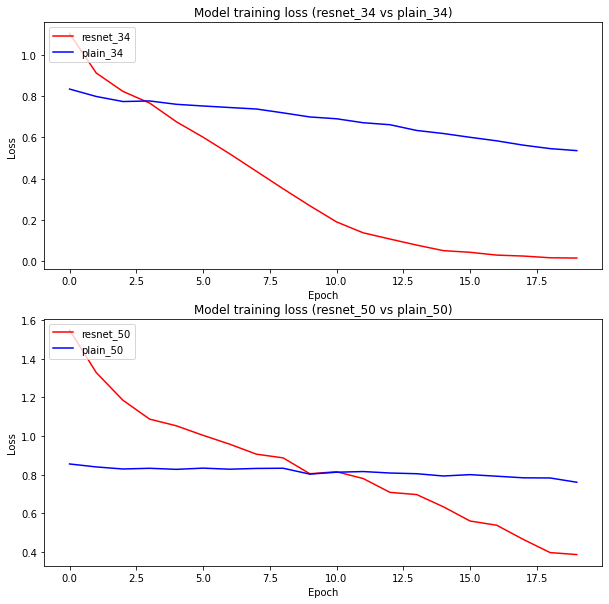

In [39]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss (resnet_34 vs plain_34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss (resnet_50 vs plain_50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.show()

#### 검증 손실(validation loss) 을 살펴보니 plain network는 학습이 진행되어도 별다른 변화가 없는것이 확인되었다. resnet모델이 더 학습이 잘 된다는 의미겠지?

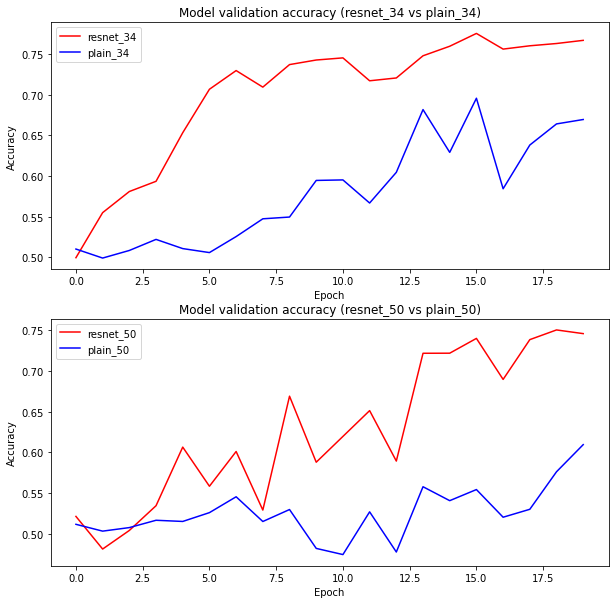

In [41]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_34 vs plain_34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy (resnet_50 vs plain_50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

#### 검증 정확도(validation accuracy)를 살펴보니 역시 resnet 모델이 학습할수록 정확도가 올라가는게 성능이 더 좋은 모델임을 알수 있었다.

## 총평

### 많은 시간을 공부했음에도 불구하고 아직도 모델하나를 설계하지 못하는게 너무 쪽팔린다 ㅜㅜ 너무 어렵고 힘든 과제였다. 그래도 아주 이해 못한건 아니니 그것으로 위안을 삼으려 한다. 나머지 두달 진짜 집중해서 공부해야겠다. 큰 도움 주신 석현님, 진선님, 윤정님께 무한 감사를 드린다. 